<a href="https://colab.research.google.com/github/respect5716/Deep-Learning-Paper-Implementation/blob/master/02_Vision/Very%20Deep%20Convolutional%20Networks%20for%20Large%20Scale%20Image%20Recognition%20(VGG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Very Deep Convolutional Networks for Large-Scale Image Recognition (VGG)

## 0. Paper

### Info
* TItle : Very Deep Convolutional Networks for Large-Scale Image Recognition
* Author : Karen Simonyan, Andrew Zisserman
* Publication : ICLR 2015, [link](https://arxiv.org/pdf/1409.1556.pdf)

### Summary
* 3x3의 작은 convolution filter만으로 층을 깊게 쌓으면 좋은 성능을 낼 수 있다.

### Differences
* dataset : Imagenet -> Intel Image Classification, [link](https://www.kaggle.com/puneet6060/intel-image-classification)
* initial num filters : 64 -> 32
* fc dimension : 4096 -> 64
* weight decay : L2 -> None
* num layer : 11 -> 7
* epoch size : 74 -> 30


## 1. Env

In [0]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Libraries
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow_datasets as tfds

In [0]:
# GPU Setting
!nvidia-smi

print(f'tensorflow version : {tf.__version__}')
print(f'available GPU list : {tf.config.list_physical_devices("GPU")}')

Wed May 27 10:55:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Hyperparameters
BASE_DIR = '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation'
INIT_NUM_FILTER = 32
FC_DIM = 64
BATCH_SIZE = 128
EPOCH_SIZE = 30

## 2. Data

In [0]:
data_path = os.path.join(BASE_DIR, 'data', 'intel_image_classification.zip')

In [0]:
!unzip $"{data_path}" -d "/content/data"

In [0]:
def build_dataframe(data_dir):
    df = {'image':[], 'label':[], 'path':[]}
    data_dir = 'data/train'
    labels = os.listdir(data_dir)

    for label in labels:
        label_dir = os.path.join(data_dir, label)
        images = os.listdir(label_dir)
        df['image'] += [i.split('.')[0] for i in images]
        df['label'] += [label for _ in range(len(images))]
        df['path'] += [os.path.join(label_dir, i) for i in images]
    
    df = pd.DataFrame(df)
    return df

In [0]:
class ImageDataset(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size, shuffle):
        self.data = data
        self.data_len = len(data)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.idx = 0
        self.on_epoch_end()
    
    def __len__(self):
        return np.ceil(len(self.data) / self.batch_size).astype(np.int)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indices = np.random.permutation(self.data_len)
        else:
            self.indices = np.arange(self.data_len)

    def load_image(self, path):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(float) / 255
        image = cv2.resize(image, (128, 128))
        return image

    def __getitem__(self, idx):
        batch_idx = self.indices[self.batch_size*idx : self.batch_size*(idx+1)]
        x = self.data.iloc[batch_idx]['path']
        x = np.stack([self.load_image(i) for i in x])
        y = self.data.iloc[batch_idx]['label']
        y = np.array(y).astype(np.int32)
        return x, y

    def next(self):
        if self.idx == self.__len__():
            self.on_epoch_end()
            self.idx = 0
        x, y = self.__getitem__(self.idx)
        self.idx += 1
        return x, y

In [0]:
train_data = build_dataframe('data/train')
test_data = build_dataframe('data/test')

In [0]:
# 데이터 예시
train_data.head()

,image,label,path
0,3196,sea,data/train/sea/3196.jpg
1,444,sea,data/train/sea/444.jpg
2,5464,sea,data/train/sea/5464.jpg
3,6756,sea,data/train/sea/6756.jpg
4,12071,sea,data/train/sea/12071.jpg


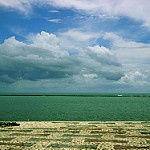

In [0]:
# 이미지 예시
Image.open(train_data['path'].iloc[0])

In [0]:
# RAW 이미지 사이즈
Image.open(train_data['path'].iloc[0]).size

(150, 150)

In [0]:
label_encoder = LabelEncoder()
label_encoder.fit(train_data['label'])
label_encoder.classes_

array(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
      dtype=object)

In [0]:
train_data['label'] = label_encoder.transform(train_data['label'])
test_data['label'] = label_encoder.transform(test_data['label'])

In [0]:
train_dataset = ImageDataset(train_data, BATCH_SIZE, True)
test_dataset = ImageDataset(test_data, BATCH_SIZE, False)

In [0]:
x, y = train_dataset.next()

In [0]:
x.shape, y.shape

((128, 128, 128, 3), (128,))

## 3. Model

In [0]:
def build_network(output_dim):
    inputs = tf.keras.layers.Input(shape=(128, 128, 3))
    x = tf.keras.layers.Conv2D(INIT_NUM_FILTER, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Conv2D(INIT_NUM_FILTER*2, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Conv2D(INIT_NUM_FILTER*4, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(INIT_NUM_FILTER*4, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(FC_DIM, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(FC_DIM, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(output_dim, activation='softmax')(x)
    
    network = tf.keras.Model(inputs, outputs)
    network.compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )
    print(network.summary())
    return network

In [0]:
network = build_network(6)

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 128)       147

## 4. Train

In [0]:
hist = network.fit(
    train_dataset,
    epochs = EPOCH_SIZE)

Epoch 1/30
110/110 [==============================] - 21s 190ms/step - loss: 1.4543 - accuracy: 0.3894
Epoch 2/30
110/110 [==============================] - 21s 190ms/step - loss: 1.1669 - accuracy: 0.5300
Epoch 3/30
110/110 [==============================] - 21s 189ms/step - loss: 1.0189 - accuracy: 0.6009
Epoch 4/30
110/110 [==============================] - 21s 188ms/step - loss: 0.9429 - accuracy: 0.6362
Epoch 5/30
110/110 [==============================] - 21s 189ms/step - loss: 0.8351 - accuracy: 0.6953
Epoch 6/30
110/110 [==============================] - 21s 188ms/step - loss: 0.7691 - accuracy: 0.7263
Epoch 7/30
110/110 [==============================] - 21s 188ms/step - loss: 0.6963 - accuracy: 0.7554
Epoch 8/30
110/110 [==============================] - 21s 188ms/step - loss: 0.6325 - accuracy: 0.7772
Epoch 9/30
110/110 [==============================] - 21s 188ms/step - loss: 0.6134 - accuracy: 0.7824
Epoch 10/30
110/110 [==============================] - 21s 188ms/step - l

## 5. Test

In [0]:
loss, acc = network.evaluate(
    test_dataset,
    batch_size = BATCH_SIZE
)

110/110 [==============================] - 20s 180ms/step - loss: 0.0585 - accuracy: 0.9819
